# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Global Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_line(img, x, y, color=[255, 0, 0], thickness=10):
    if len(x) == 0: 
        return
    
    line_params = np.polyfit(x, y, 1) 
    
    m = line_params[0]
    b = line_params[1]
    
    max_y = img.shape[0]
    #max_x = img.shape[1]
    y1 = max_y
    x1 = int((y1 - b)/m)
    y2 = int((max_y/2)) + 60
    x2 = int((y2 - b)/m)
    cv2.line(img, (x1, y1), (x2, y2), [255, 0, 0], 4)

    
def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    left_points_x = []
    left_points_y = []
    right_points_x = []
    right_points_y = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y1 - y2)/(x1 - x2)
            
            if abs(m) < 0.3:
                continue
            
            if m < 0:
                left_points_x.append(x1)
                left_points_y.append(y1)
                left_points_x.append(x2)
                left_points_y.append(y2)
            else:
                right_points_x.append(x1)
                right_points_y.append(y1)
                right_points_x.append(x2)
                right_points_y.append(y2)
                
    draw_line(img, left_points_x, left_points_y, color, thickness)
    draw_line(img, right_points_x, right_points_y, color, thickness)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
    

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Testing Algorithm Step by Step

For testing purposes we execute all the steps of the algorithm for ONE single image: solidWhiteRight.jpg

### Step 1. Read in the image

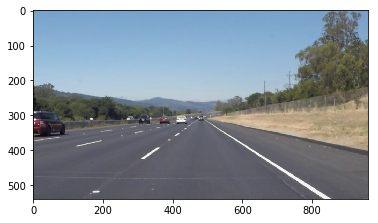

In [3]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(image)

### Step 2. Grayscale the image

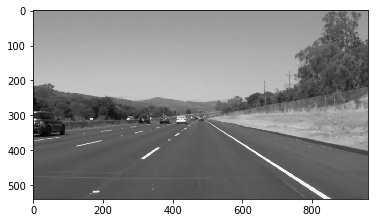

In [4]:
gray = grayscale(image)
plt.imshow(gray, cmap='gray')

### Step 3. Gaussian Smoothing and Canny Edge Detection

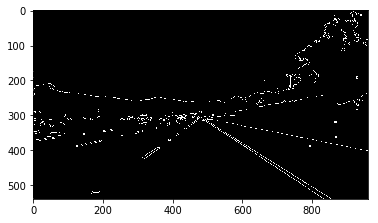

In [5]:
# Gaussian smoothing with a defined kernel size
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

# Canny Edge Detection Alghorithm
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold,high_threshold)
plt.imshow(edges, cmap='Greys_r')

### Step 4. Find Vertices

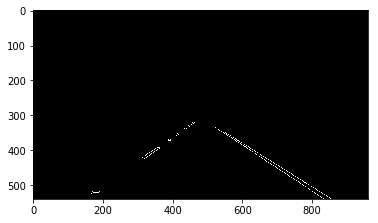

In [6]:
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges, cmap='Greys_r')

### Step 5. Hough Transform
```
rho = distance resolution in pixels of the Hough grid
theta = angular resolution in radians of the Hough grid
threshold = minimum number of votes (intersections in Hough grid cell)
min_line_len = minimum number of pixels making up a line
max_line_gap = maximum gap in pixels between connectable line segments
```

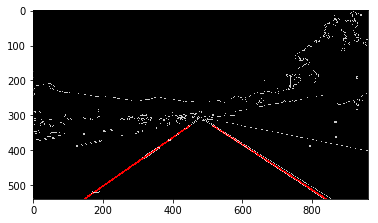

In [7]:
# Hough transform parameters
rho = 2 
theta = np.pi/180 
threshold = 30    
min_line_len = 15 
max_line_gap = 20 

# Find lines
line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)


### Step. 6 Original image with lane lines

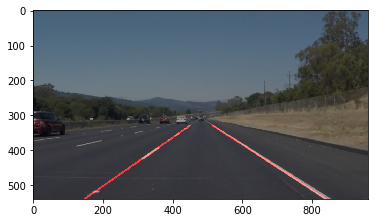

In [8]:
lines_edges = weighted_img(line_image, image, 0.6)
plt.imshow(lines_edges)

## Test on Images

### Process Image Functions

The following function are used to test the algorithms in all images

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Grayscale the image
    gray = grayscale(image)
    # plt.imshow(gray, cmap='gray')
    
    # Gaussian smoothing with a defined kernel size
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Canny Edge Detection Alghorithm
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold,high_threshold)
    # plt.imshow(edges, cmap='Greys_r')
    
    # Find vertices
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    # plt.imshow(masked_edges, cmap='Greys_r')
    
    # Hough transform
    """
    rho = distance resolution in pixels of the Hough grid
    theta = angular resolution in radians of the Hough grid
    threshold = minimum number of votes (intersections in Hough grid cell)
    min_line_len = minimum number of pixels making up a line
    max_line_gap = maximum gap in pixels between connectable line segments
    """
    rho = 2 
    theta = np.pi/180 
    threshold = 30    
    min_line_len = 15 
    max_line_gap = 20 
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(line_image, image, 0.6)
    
    return result

def process_and_save_image(image_name):
    image = mpimg.imread('test_images/' + image_name)
    image_with_lanes = process_image(image)
    mpimg.imsave('test_images_output/' + image_name, image_with_lanes)
    
    return image_with_lanes

### Image 1 - solidYellowLeft.jpg

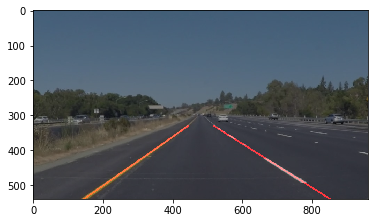

In [10]:
image_with_lanes = process_and_save_image('solidYellowLeft.jpg')
plt.imshow(image_with_lanes)

### Image 2 - solidYellowCurve.jpg

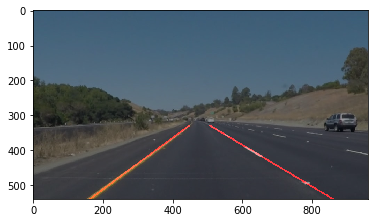

In [11]:
image_with_lanes = process_and_save_image('solidYellowCurve.jpg')
plt.imshow(image_with_lanes)

### Image 3 - solidWhiteRight.jpg

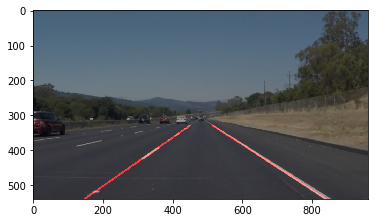

In [12]:
image_with_lanes = process_and_save_image('solidWhiteRight.jpg')
plt.imshow(image_with_lanes)

### Image 4 - solidYellowCurve2.jpg

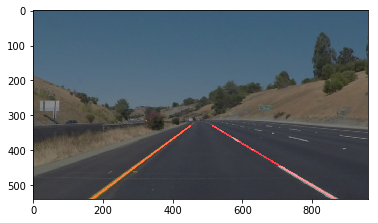

In [13]:
image_with_lanes = process_and_save_image('solidYellowCurve2.jpg')
plt.imshow(image_with_lanes)

### Image 5 - solidWhiteCurve.jpg

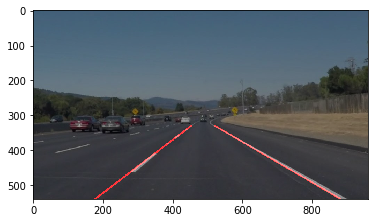

In [14]:
image_with_lanes = process_and_save_image('solidWhiteCurve.jpg')
plt.imshow(image_with_lanes)

### Image 6 - whiteCarLaneSwitch.jpg

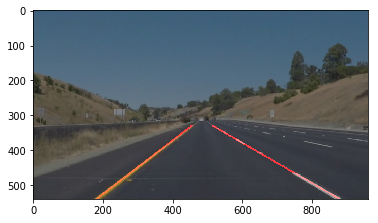

In [15]:
image_with_lanes = process_and_save_image('whiteCarLaneSwitch.jpg')
plt.imshow(image_with_lanes)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Video 1 -  solidWhiteRight.mp4

In [18]:
video_output = 'test_videos_output/solid_white_right.mp4'
clip = VideoFileClip("test_videos/solidWhiteRight.mp4")
video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solid_white_right.mp4
[MoviePy] Writing video test_videos_output/solid_white_right.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solid_white_right.mp4 

CPU times: user 2.71 s, sys: 246 ms, total: 2.96 s
Wall time: 13.9 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### Video 2 -  solidYellowLeft.mp4

In [20]:
video_output = 'test_videos_output/solid_yellow_left.mp4'
clip = VideoFileClip("test_videos/solidYellowLeft.mp4")
video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solid_yellow_left.mp4
[MoviePy] Writing video test_videos_output/solid_yellow_left.mp4


100%|█████████▉| 681/682 [00:41<00:00, 15.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solid_yellow_left.mp4 

CPU times: user 8.64 s, sys: 699 ms, total: 9.34 s
Wall time: 43.4 s


Video:

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
